In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import community


c:\Users\Dell 5520\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
df_original = pd.read_csv('data/primaryschool.csv', header=None, delimiter='\t', names = ['time', 'u', 'v', 'grade_u', 'grade_v'])
print(df_original.head())

metadata = pd.read_csv('data/metadata.txt', header=None, delimiter='\t', names = ['id', 'grade', 'gender'])
print(metadata.head())

    time     u     v grade_u grade_v
0  31220  1558  1567      3B      3B
1  31220  1560  1570      3B      3B
2  31220  1567  1574      3B      3B
3  31220  1632  1818      4B      4B
4  31220  1632  1866      4B      4B
     id grade gender
0  1426    5B      M
1  1427    5B      F
2  1428    5B      M
3  1429    5B      F
4  1430    5B      M


In [3]:
# Sort dataframe by source, target, and timestamp
df_original = df_original.sort_values(by=['u', 'v', 'time'])

# Initialize an empty list to store the results
df = []

# Iterate through the dataframe to calculate weights
for (u, v), group in df_original.groupby(['u', 'v']):
    timestamps = group['time'].tolist()
    weight = 1
    first_time = timestamps[0]
    for i in range(1, len(timestamps)):
        if timestamps[i] == timestamps[i-1] + 20:
            weight += 1
        else:
            df.append({'u': u, 'v': v, 'weight': weight, 'time': first_time})
            weight = 1
            first_time = timestamps[i]
    df.append({'u': u, 'v': v, 'weight': weight, 'time': first_time})

# Create a new dataframe from the result
df = pd.DataFrame(df)

print(df.head(10))

      u     v  weight   time
0  1426  1427       1  36740
1  1426  1427       2  36940
2  1426  1427       2  39640
3  1426  1427       2  52820
4  1426  1427       1  54760
5  1426  1427       2  56580
6  1426  1427       1  60680
7  1426  1427       2  61080
8  1426  1427       1  61160
9  1426  1427       2  61320


## USING time threashold 

In [4]:
thr = 5
df = df[df['weight'] >= thr]

In [5]:
grade_dict = {"1A": "red", "1B": "red", "2A": "orange", "2B": "orange", "3A": "gray", "3B": "gray", "4A": "cyan", "4B": "cyan", "5A": "blue", "5B": "blue", "Teachers": "black"}
grade_dict_more = {"1A": "firebrick", "1B": "red", "2A": "orange", "2B": "sandybrown", "3A": "slategray", "3B": "gray", "4A": "darkturquoise", "4B": "cyan", "5A": "cornflowerblue", "5B": "blue", "Teachers": "black"}

node_grade = {}
for _, row in metadata.iterrows():
    node_grade[row['id']] = row['grade']

In [6]:
G = nx.Graph()
for _, row in metadata.iterrows():
    if row['grade'] != "Teachers":
        G.add_node(row['id'], color=grade_dict_more[row['grade']])

for _, edge in df.iterrows():
    if node_grade[edge['u']] != "Teachers" and node_grade[edge['v']] != "Teachers":
        G.add_edge(edge['u'], edge['v'], weight=edge['weight'])


In [7]:
group = {grade: metadata[metadata['grade'] == grade]['id'].tolist() for grade in metadata['grade'].unique()}
group = {'1A': group['1A'], '1B': group['1B'], '5A': group['5A'], '5B': group['5B']}

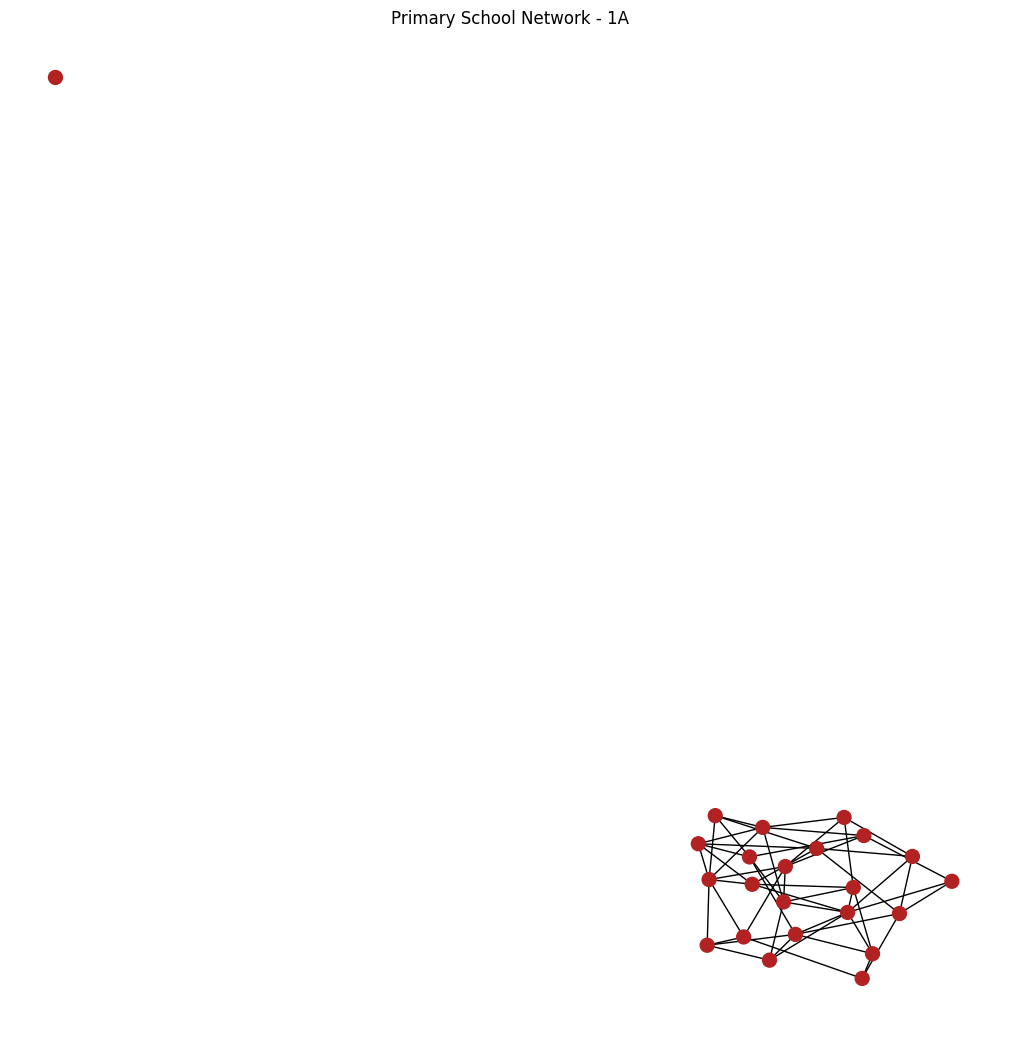

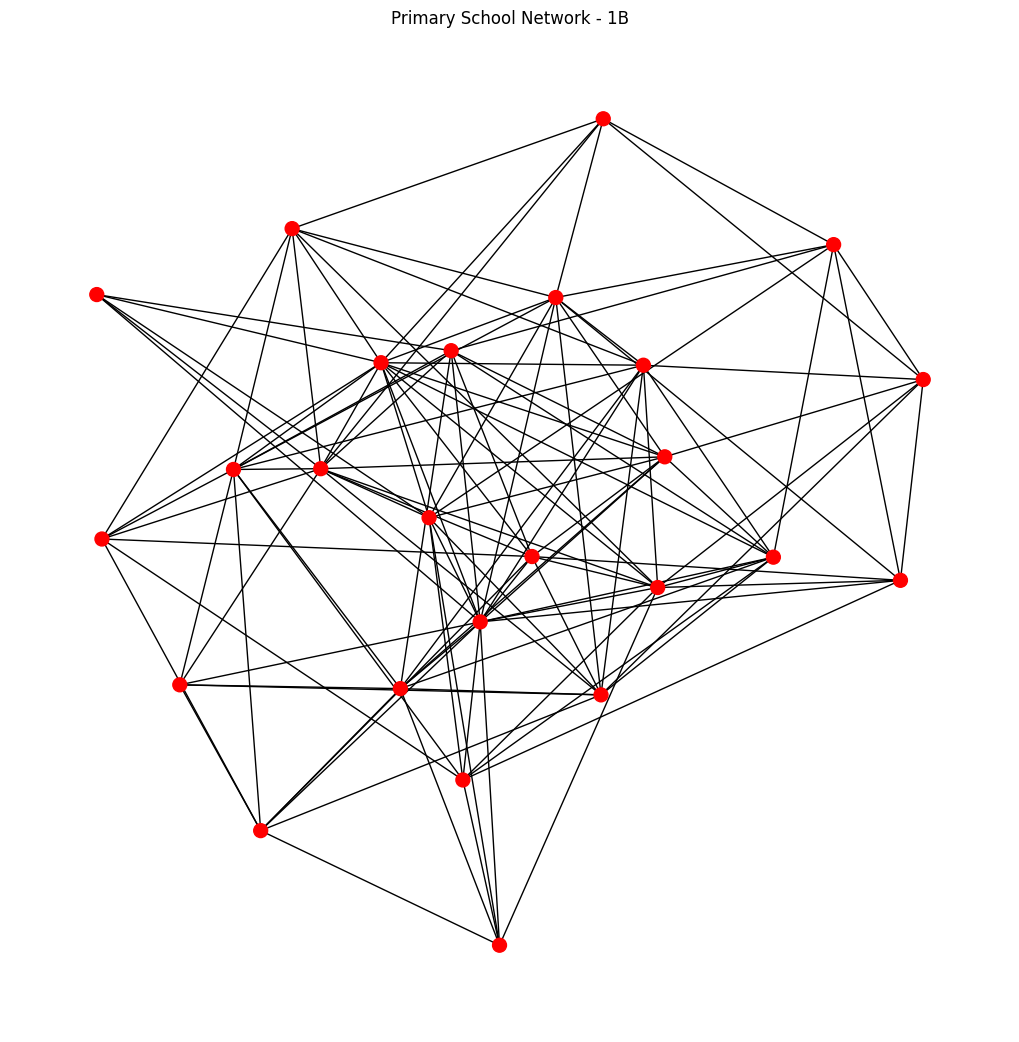

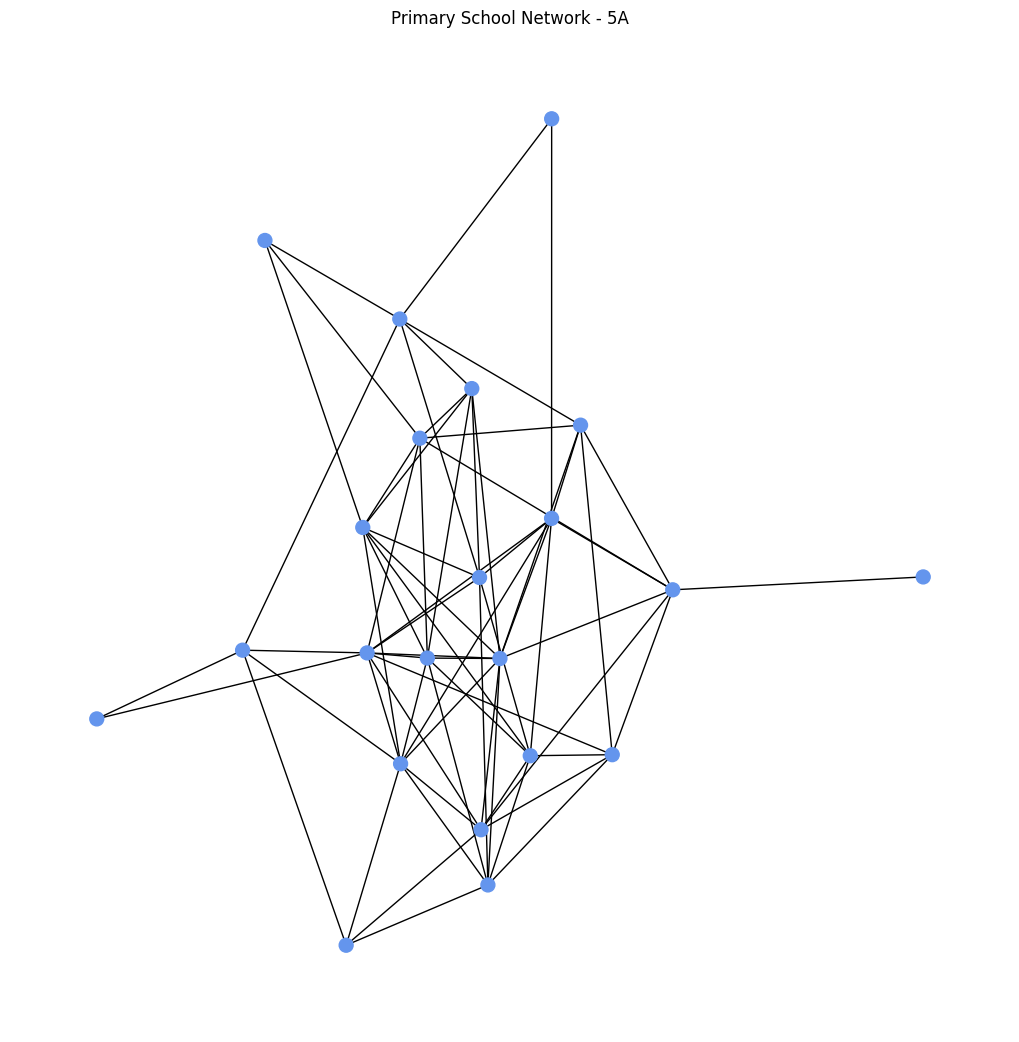

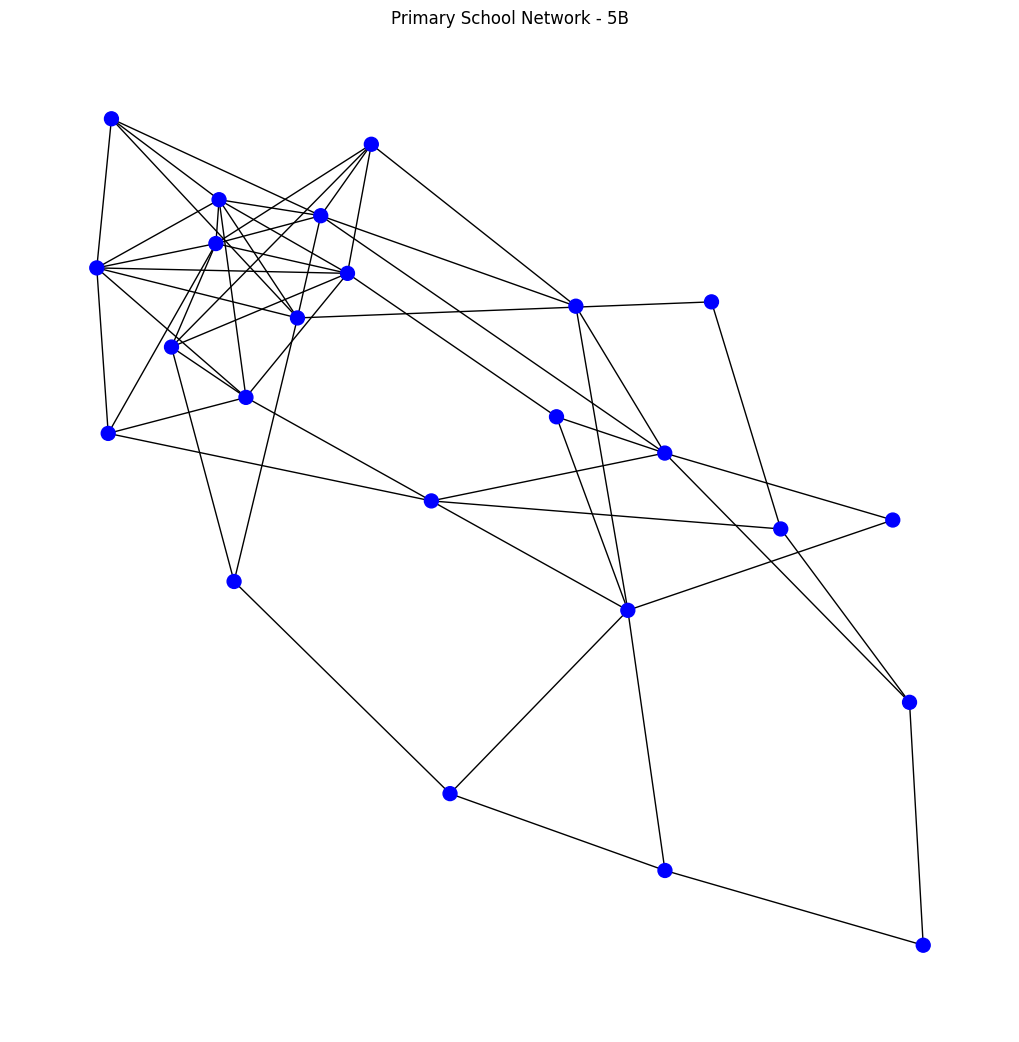

In [8]:
for grade, nodes in group.items():
    subgraph = G.subgraph(nodes)
    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(10, 10))
    nx.draw(subgraph, pos, node_color=[grade_dict_more[node_grade[node]] for node in subgraph.nodes()], with_labels=False, node_size=100)
    plt.title(f'Primary School Network - {grade}')
    plt.show()

In [9]:
for grade, nodes in group.items():
    subgraph = G.subgraph(nodes)
    print(f'Grade: {grade}, Number of nodes: {len(subgraph.nodes())}, Number of edges: {len(subgraph.edges())}')

Grade: 1A, Number of nodes: 23, Number of edges: 53
Grade: 1B, Number of nodes: 25, Number of edges: 115
Grade: 5A, Number of nodes: 22, Number of edges: 68
Grade: 5B, Number of nodes: 24, Number of edges: 55


In [10]:
for grade, nodes in group.items():
    df_group = df[df['u'].isin(nodes) & df['v'].isin(nodes)]
    subgraph = G.subgraph(nodes)

    avg_length = round(df_group["weight"].mean(), 2)
    avg_degree = round(np.mean(list(dict(subgraph.degree()).values())), 2)
    max_degree = round(np.max(list(dict(subgraph.degree()).values())), 2)
    min_degree = round(np.min(list(dict(subgraph.degree()).values())), 2)

    print(f'Grade: {grade}, Average length: {avg_length}. Av. degree: {avg_degree}. Max degree: {max_degree}. Min degree: {min_degree}.')


Grade: 1A, Average length: 7.38. Av. degree: 4.61. Max degree: 8. Min degree: 0.
Grade: 1B, Average length: 7.5. Av. degree: 9.2. Max degree: 16. Min degree: 5.
Grade: 5A, Average length: 7.36. Av. degree: 6.18. Max degree: 10. Min degree: 1.
Grade: 5B, Average length: 8.71. Av. degree: 4.58. Max degree: 7. Min degree: 2.


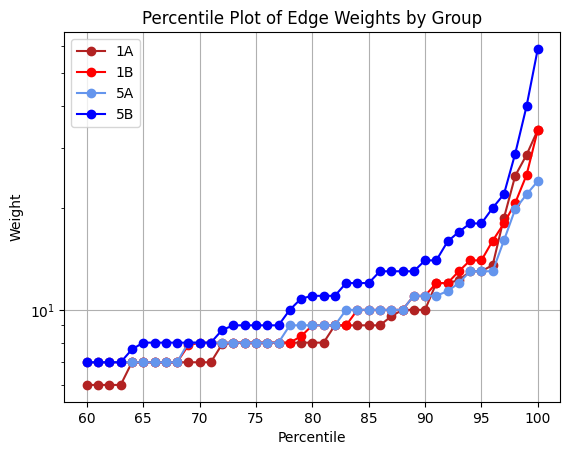

In [11]:
for grade, nodes in group.items():
    subgraph = G.subgraph(nodes)
    df_group = df[df['u'].isin(nodes) & df['v'].isin(nodes)]
    percentiles = np.percentile(df_group['weight'], np.arange(0, 101, 1))

    # Plot the percentiles
    plt.plot(np.arange(60, 101, 1), percentiles[60:], marker='o', label=grade, color=grade_dict_more[grade])

plt.xlabel('Percentile')
plt.ylabel('Weight')
plt.yscale('log')
plt.title('Percentile Plot of Edge Weights by Group')
plt.legend()
plt.grid(True)
plt.show()


Sub-Communities


In [12]:
import importlib
import community_visualization

# Reload the module
importlib.reload(community_visualization)

<module 'community_visualization' from 'c:\\Users\\Dell 5520\\Documents\\UCL_Networks\\community_visualization.py'>

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from community_visualization import assign_colors_to_communities, draw_graph_with_communities

In [14]:
def draw_graph_per_community(G, pos, node_colors, communities):
    fig, axes = plt.subplots(1, len(communities), figsize=(4*len(communities), 4))
    print(len(communities))
    if len(communities) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, community in zip(axes, communities):
        subgraph = G.subgraph(community)
        nx.draw(subgraph, pos, ax=ax, node_color=[grade_dict_more[node_grade[node]]for node in community], with_labels=True, node_size=100, edge_color='gray')
        ax.set_title(f"Community {communities.index(community) + 1}")

    plt.show()

grade 1A. Number of communities: 21
Communities: [({1792, 1760, 1764, 1796, 1798, 1766, 1768, 1770, 1774, 1778, 1752, 1757}, {1799}, {1761, 1767, 1772, 1711, 1775, 1783, 1787, 1789, 1790, 1759}), ({1792, 1760, 1764, 1796, 1798, 1768, 1770, 1774, 1778, 1757}, {1799}, {1761, 1767, 1772, 1711, 1775, 1783, 1787, 1789, 1790, 1759}, {1752, 1766}), ({1792, 1760, 1764, 1796, 1798, 1768, 1770, 1774, 1778, 1757}, {1799}, {1761, 1767, 1711, 1783, 1787, 1759}, {1752, 1766}, {1772, 1789, 1790, 1775}), ({1792, 1798}, {1760, 1796, 1764, 1768, 1770, 1774, 1778, 1757}, {1799}, {1761, 1767, 1711, 1783, 1787, 1759}, {1752, 1766}, {1772, 1789, 1790, 1775}), ({1792, 1798}, {1760, 1796, 1768, 1778, 1757}, {1799}, {1761, 1767, 1711, 1783, 1787, 1759}, {1752, 1766}, {1770, 1764, 1774}, {1772, 1789, 1790, 1775}), ({1792, 1798}, {1760, 1796, 1768, 1778, 1757}, {1799}, {1759, 1787, 1711}, {1752, 1766}, {1761, 1767, 1783}, {1770, 1764, 1774}, {1772, 1789, 1790, 1775}), ({1792, 1798}, {1796}, {1799}, {1759, 1787, 

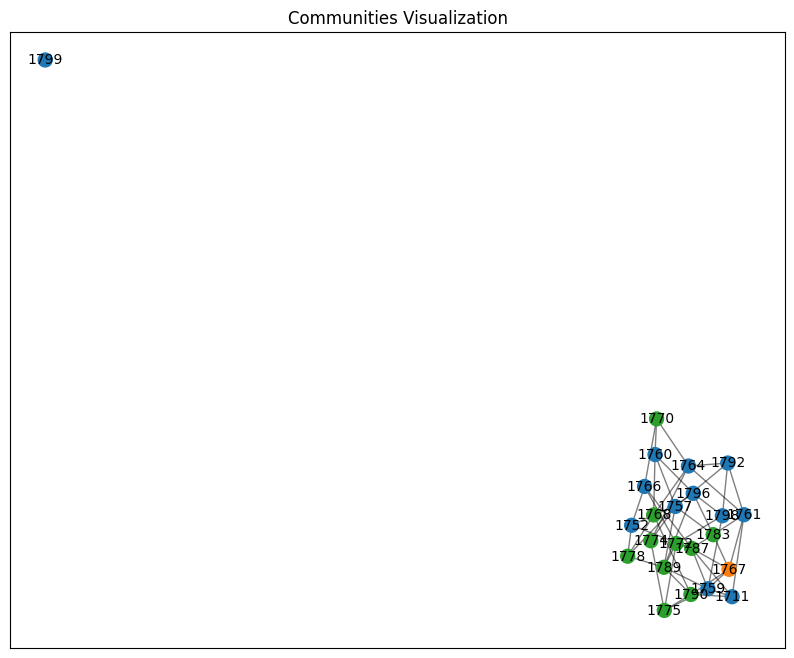

3


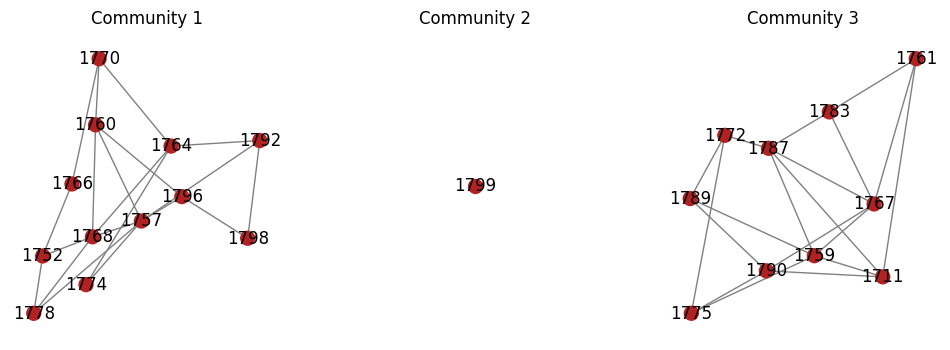

4


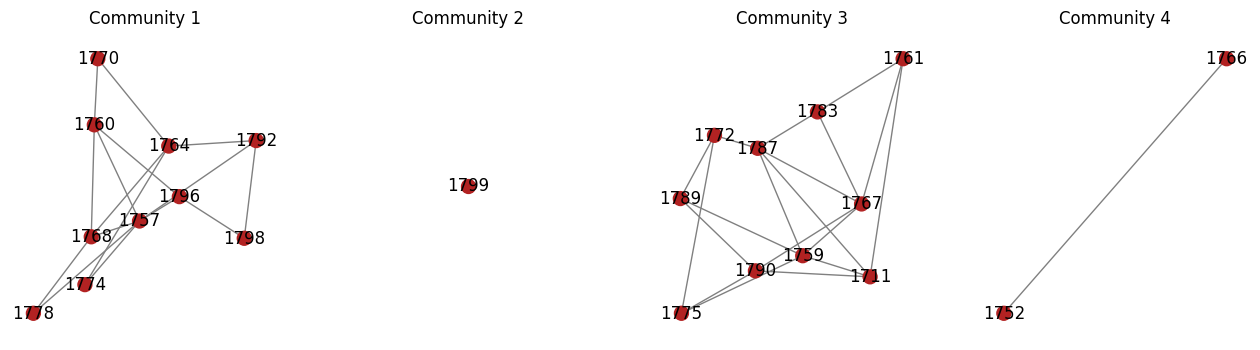

5


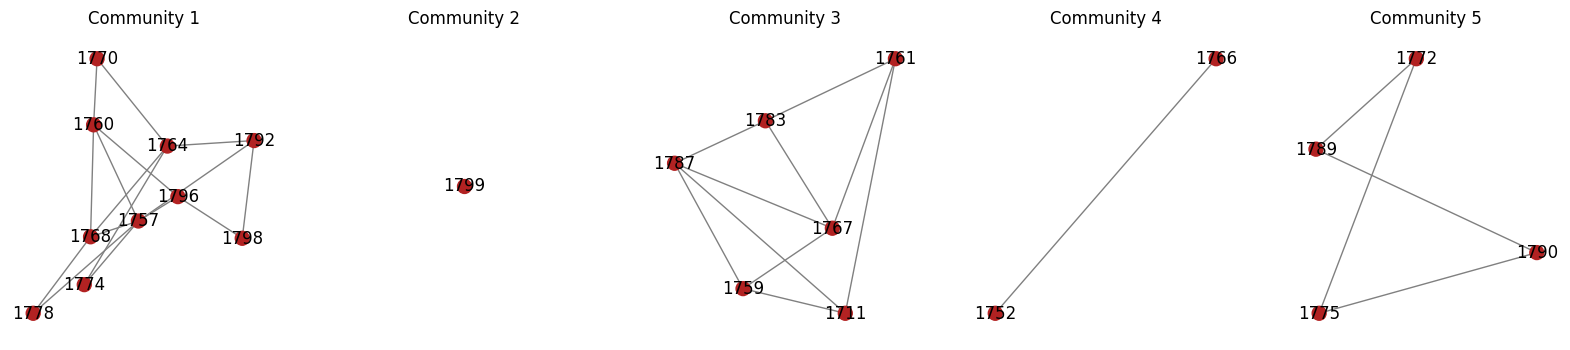

6


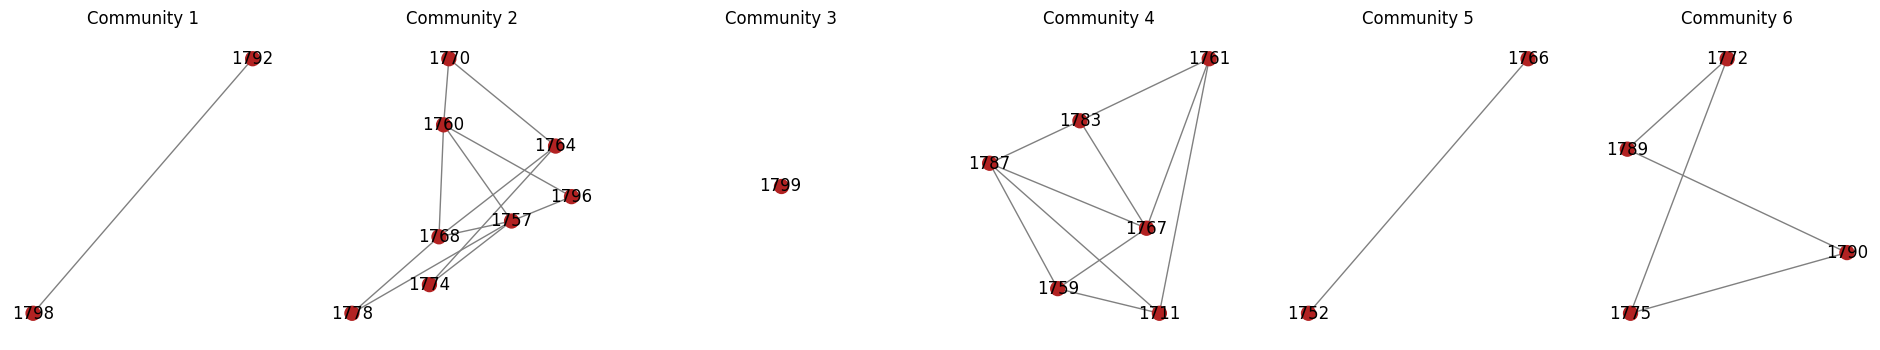

grade 1B. Number of communities: 24
Communities: [({1664, 1665, 1666, 1920, 1670, 1673, 1674, 1675, 1680, 1681, 1682, 1684, 1687, 1688, 1695, 1696, 1697, 1698, 1765, 1779, 1908, 1912, 1661, 1663}, {1656}), ({1664, 1665, 1666, 1920, 1670, 1673, 1674, 1675, 1680, 1681, 1682, 1684, 1688, 1695, 1696, 1697, 1698, 1765, 1779, 1908, 1912, 1661, 1663}, {1687}, {1656}), ({1664, 1665, 1666, 1920, 1670, 1673, 1674, 1675, 1680, 1681, 1684, 1688, 1695, 1696, 1697, 1698, 1765, 1779, 1908, 1912, 1661, 1663}, {1682}, {1687}, {1656}), ({1664}, {1920, 1665, 1666, 1670, 1673, 1674, 1675, 1680, 1681, 1684, 1688, 1695, 1696, 1697, 1698, 1765, 1779, 1908, 1912, 1661, 1663}, {1682}, {1687}, {1656}), ({1664}, {1920, 1665, 1666, 1670, 1674, 1675, 1680, 1681, 1684, 1688, 1695, 1696, 1697, 1698, 1765, 1779, 1908, 1912, 1661, 1663}, {1673}, {1682}, {1687}, {1656}), ({1664}, {1920, 1665, 1666, 1670, 1674, 1675, 1680, 1681, 1684, 1688, 1695, 1696, 1697, 1698, 1765, 1779, 1908, 1912, 1663}, {1673}, {1682}, {1687}, {

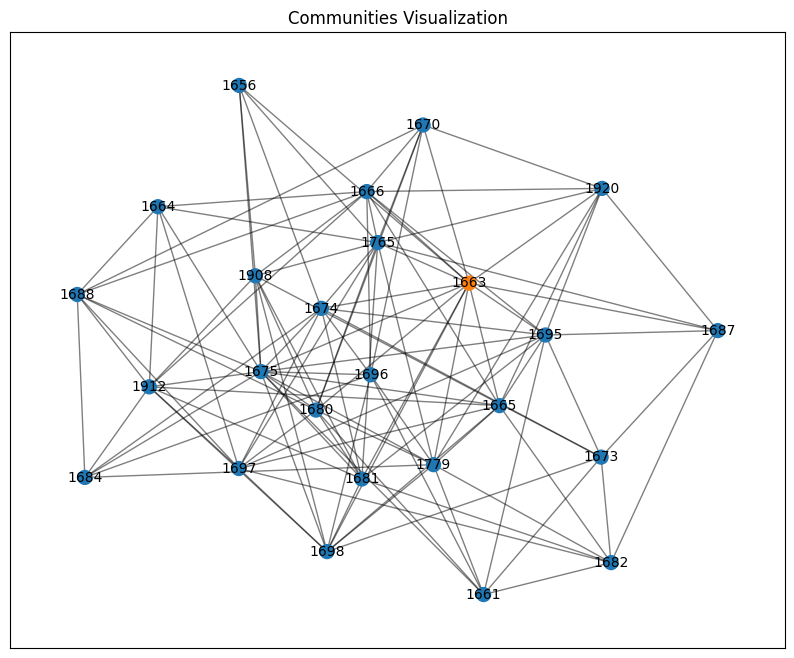

2


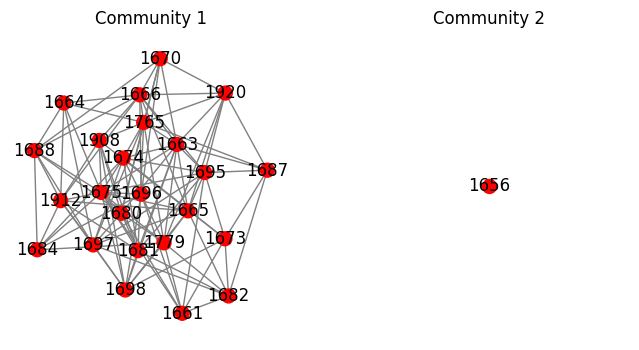

3


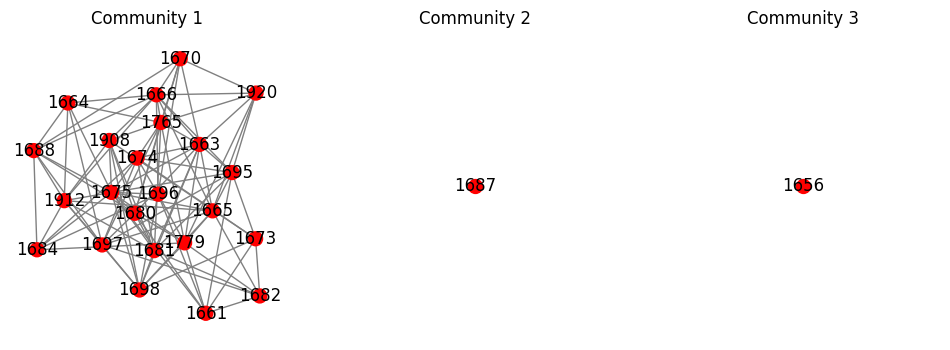

4


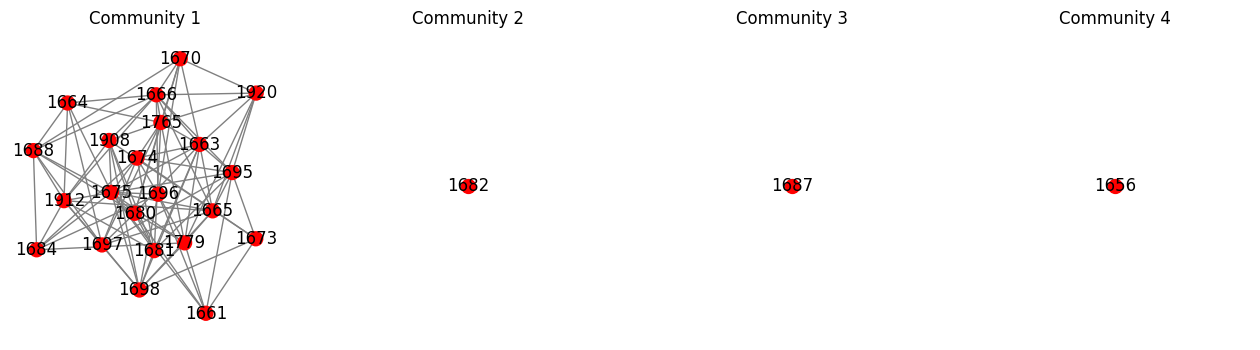

5


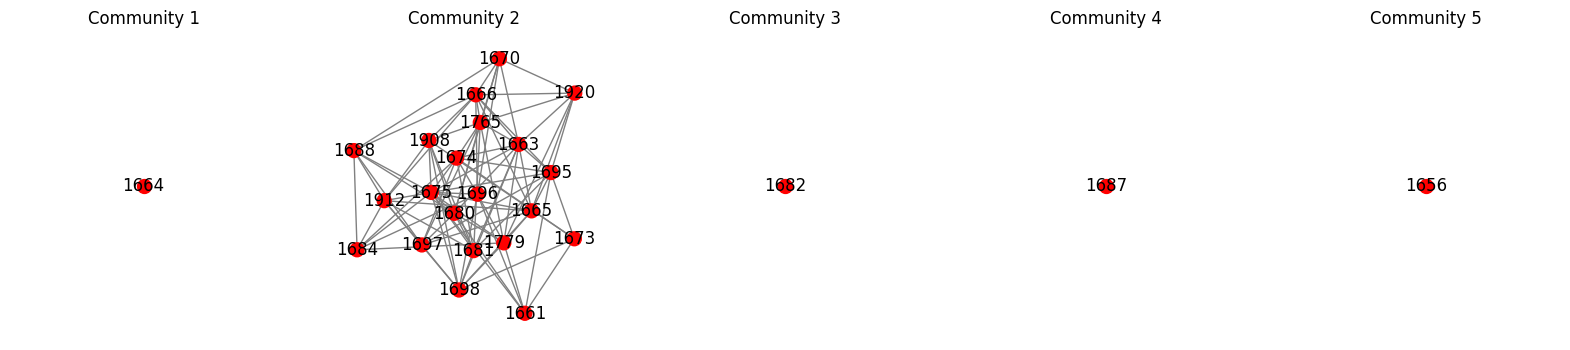

grade 5A. Number of communities: 21
Communities: [({1451, 1452, 1453, 1457, 1458, 1459, 1461, 1468, 1477, 1479, 1483, 1493, 1495, 1751, 1498, 1501, 1502, 1637, 1516, 1520, 1522}, {1511}), ({1451, 1452, 1453, 1457, 1458, 1459, 1461, 1468, 1477, 1483, 1493, 1751, 1495, 1498, 1501, 1502, 1637, 1516, 1520, 1522}, {1479}, {1511}), ({1451, 1452, 1453, 1457, 1458, 1459, 1461, 1468, 1477, 1493, 1751, 1495, 1498, 1501, 1502, 1637, 1516, 1520, 1522}, {1479}, {1483}, {1511}), ({1477, 1637, 1451, 1452, 1453, 1516, 1520, 1457, 1458, 1522, 1459, 1493, 1461, 1751, 1498, 1468, 1501, 1502}, {1479}, {1483}, {1495}, {1511}), ({1451}, {1477, 1637, 1452, 1453, 1516, 1520, 1457, 1458, 1522, 1459, 1461, 1493, 1751, 1498, 1468, 1501, 1502}, {1479}, {1483}, {1495}, {1511}), ({1451}, {1477, 1637, 1452, 1453, 1516, 1457, 1458, 1522, 1459, 1461, 1493, 1751, 1498, 1468, 1501, 1502}, {1479}, {1483}, {1495}, {1511}, {1520}), ({1451}, {1477, 1637, 1452, 1453, 1516, 1457, 1458, 1522, 1459, 1461, 1493, 1498, 1468, 1501

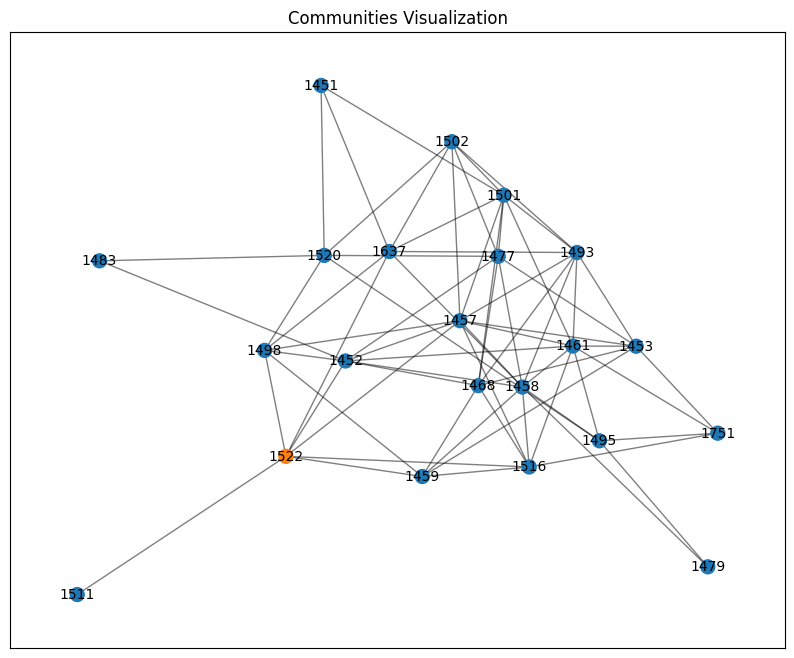

2


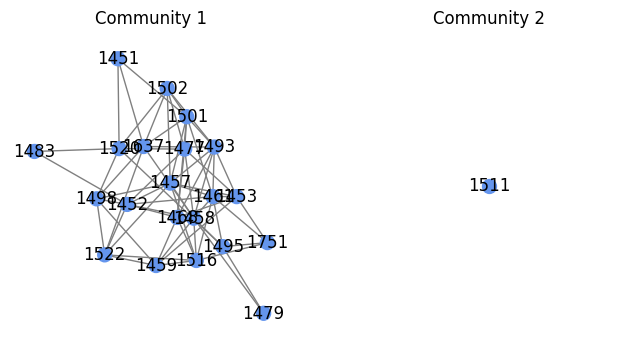

3


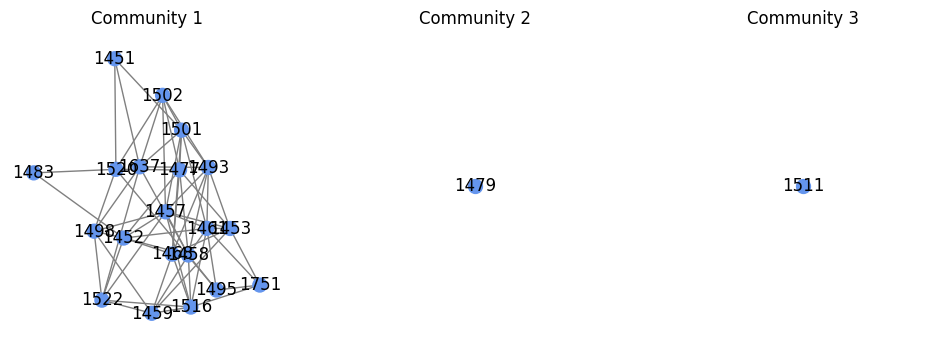

4


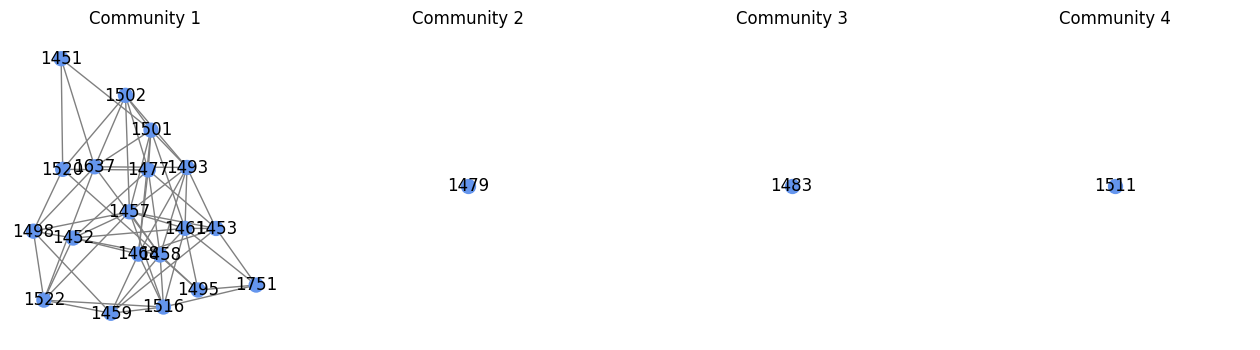

5


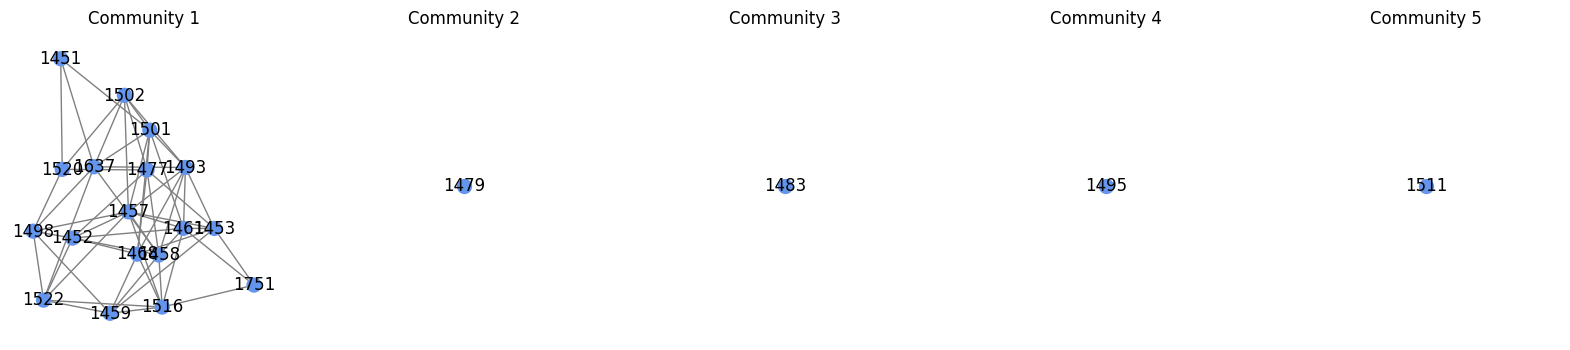

grade 5B. Number of communities: 23
Communities: [({1441, 1439, 1578, 1486, 1426, 1428, 1750, 1435, 1471}, {1443, 1475, 1480, 1482, 1489, 1585, 1427, 1429, 1430, 1431, 1592, 1465, 1434, 1563, 1437}), ({1441, 1439, 1578, 1486, 1426, 1428, 1750, 1435, 1471}, {1443, 1475, 1480, 1489, 1585, 1427, 1429, 1431, 1592, 1465, 1434, 1563, 1437}, {1482, 1430}), ({1441, 1439, 1578, 1486, 1426, 1428, 1750, 1435, 1471}, {1443, 1475, 1480, 1489, 1427, 1429, 1431, 1592, 1465, 1434, 1563, 1437}, {1482, 1430}, {1585}), ({1471, 1486, 1426, 1428, 1439}, {1443, 1475, 1480, 1489, 1427, 1429, 1431, 1592, 1465, 1434, 1563, 1437}, {1482, 1430}, {1441, 1578, 1435, 1750}, {1585}), ({1471, 1486, 1426, 1428, 1439}, {1443, 1475, 1480, 1489, 1427, 1429, 1431, 1465, 1434, 1563, 1437}, {1482, 1430}, {1441, 1578, 1435, 1750}, {1585}, {1592}), ({1471, 1486, 1426, 1428, 1439}, {1443, 1489, 1427, 1429, 1431, 1465, 1563, 1437}, {1482, 1430}, {1480, 1434, 1475}, {1441, 1578, 1435, 1750}, {1585}, {1592}), ({1471, 1486, 1426, 

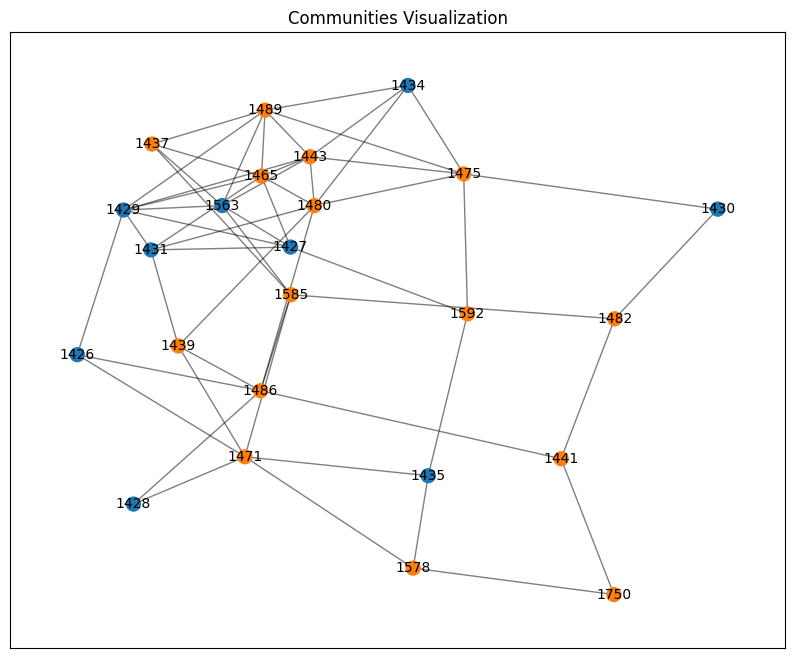

2


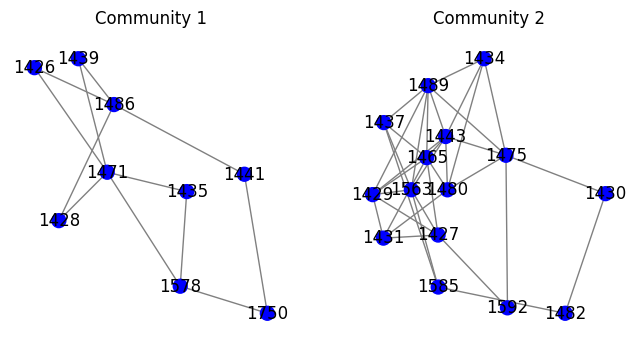

3


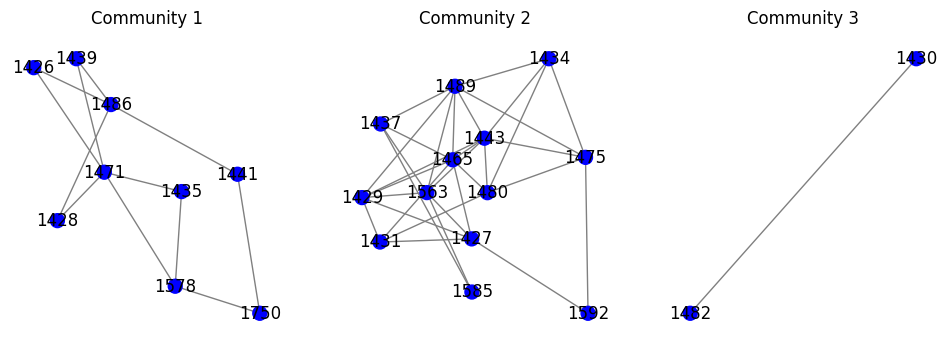

4


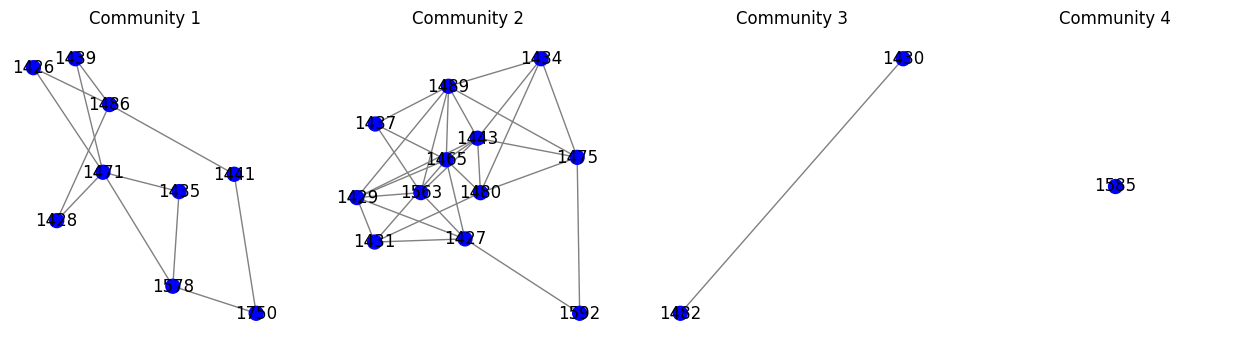

5


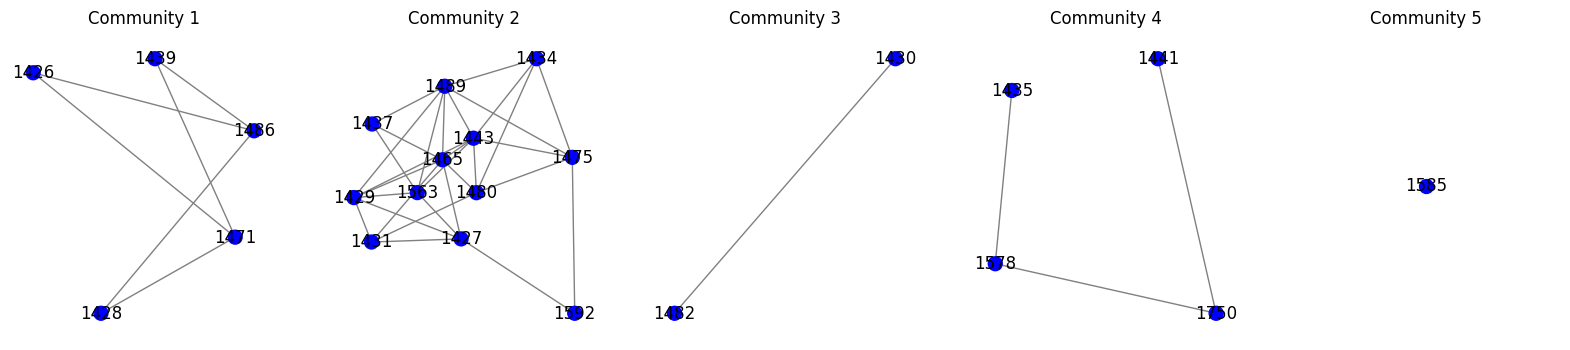

In [ ]:
for grade, nodes in group.items():
    subgraph = G.subgraph(nodes)
    df_group = df[df['u'].isin(nodes) & df['v'].isin(nodes)]

    communities = list(community.########33   ####khfaiohafn############# #(subgraph))
    print(f'grade {grade}. Number of communities: {len(communities)}')
    print(f'Communities: {communities}')

    pos, node_colors = assign_colors_to_communities(subgraph, communities)

    draw_graph_with_communities(subgraph, pos, node_colors)

    # draw_graph_per_community(subgraph, pos, node_colors, communities[0])

    # draw_graph_per_community(subgraph, pos, node_colors, communities[1])

    # draw_graph_per_community(subgraph, pos, node_colors, communities[2])

    draw_graph_per_community(subgraph, pos, node_colors, communities[3])


## Temporal Properties


*"https://dl.acm.org/doi/pdf/10.1145/1592665.1592674"*
**Temporal Distance Metrics for Social Network Analysis
**

*  The
key measure that we propose is the average temporal path
length of a network that gives us a global measure of how
fast information spreads to all the nodes of the network by
means of transitive connections between them.


In [16]:
# Implement the temporal distance algorithm
def temporal_distance(G, source, tmin, tmax, h):
    # Initialize D and R
    D = {node: float('inf') for node in G.nodes()}
    R = {node: False for node in G.nodes()}
    D[source] = 0
    R[source] = True

    # Iterate over time windows
    for t in range(tmin, tmax + 1, 20):  # Assuming time window of 20
        # Perform DFS within the horizon h
        stack = [(source, 0)]
        while stack:
            node, depth = stack.pop()
            if depth < h:
                for neighbor in G.neighbors(node):
                    if not R[neighbor] and G[node][neighbor]['time'] <= t:
                        R[neighbor] = True
                        D[neighbor] = min(D[neighbor], D[node] + 1)
                        stack.append((neighbor, depth + 1))

    return D

# Example usage
tmin = df['time'].min()
tmax = df['time'].max()
h = 3  # Example horizon
source = 1426  # Example source node
temporal_distances = temporal_distance(G, source, tmin, tmax, h)
print(temporal_distances)

KeyError: 'time'